<a href="https://colab.research.google.com/github/20184415/qwer/blob/main/%EC%A6%9D%EA%B0%802.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [5]:
from PIL import Image
import numpy as np
import os
import re

def extract_label_from_filename(filename):
    # 파일 이름에서 카테고리 검색
    categories = {
        'apple': 'apple',
        'car': 'car',
        'cucumber': 'cucumber',  # 'image'는 'cucumber'로 매핑
        'zucchini': 'zucchini',    # 'r0_'는 'zucchini'로 매핑
        'pear': 'pear'        # 'pear' 추가
    }

    for keyword, category in categories.items():
        if re.search(re.escape(keyword), filename, re.IGNORECASE):
            return category

    return None  # 일치하는 카테고리가 없는 경우 None 반환

# 이미지가 저장된 디렉토리 경로
image_dir = '/content/drive/MyDrive/Colab Notebooks/123'
image_files = os.listdir(image_dir)

labels = []
label_mapping = {'apple': 0, 'car': 1, 'cucumber': 2, 'zucchini': 3, 'pear': 4}

for image_file in image_files:
    label_name = extract_label_from_filename(image_file)
    if label_name:
        if label_name in label_mapping:
            labels.append(label_mapping[label_name])
        else:
            print(f"Warning: {label_name} is not in label mapping.")
    else:
        print(f"Warning: No valid category found in {image_file}.")




In [6]:
images = []
labels = []

for image_file in image_files:
    label_name = extract_label_from_filename(image_file)
    if label_name and label_name in label_mapping:
        # 이미지 경로
        image_path = os.path.join(image_dir, image_file)
        # 이미지 열기 및 처리
        image = Image.open(image_path)
        image = image.resize((28, 28))  # 이미지 크기 조정
        image = image.convert('L')  # 흑백 변환
        image_array = np.array(image) / 255.0  # 스케일링

        # 이미지와 레이블을 리스트에 추가
        images.append(image_array)
        labels.append(label_mapping[label_name])
    else:
        print(f"Skipping file {image_file} due to invalid category or missing label.")

# 이미지와 레이블 배열로 변환
images = np.array(images).reshape(-1, 28, 28, 1)
labels = np.array(labels)



In [7]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(images, labels, test_size=0.2, random_state=42)


In [8]:
print(len(images))
print(len(labels))


2482
2482


In [11]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# CNN 모델 정의
model = keras.Sequential()

model.add(layers.Conv2D(32, kernel_size=3, activation='relu',
                        padding='same', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, kernel_size=3, activation='relu',
                        padding='same'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # 가중치 규제 추가
model.add(layers.Dropout(0.5))  # 드롭아웃 추가
model.add(layers.Dense(len(label_mapping), activation='softmax'))
model.summary()

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 체크포인트 콜백 및 얼리 스토핑 콜백 설정
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# 모델 학습
history = model.fit(train_scaled, train_target, epochs=50,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

# 모델 평가
test_loss, test_accuracy = model.evaluate(val_scaled, val_target)
print(f"Validation accuracy: {test_accuracy:.4f}")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1568)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              

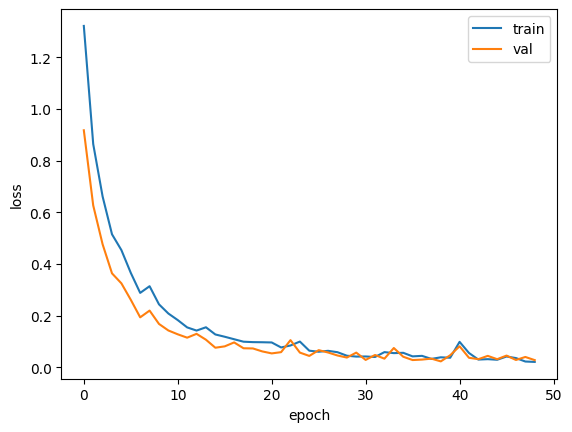

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()